## Install the package dependencies before running this notebook

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import lstm_encoder_decoder2

In [19]:
import time
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [20]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "../../argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "val", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    outputs = None
    
    if split == "train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    elif split == 'test':
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        
    else:
        print('\"split\" should be train, val, or test.')
        inputs = None

    return inputs, outputs

class ArgoverseDataset(Dataset):
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.split = split
        self.input_positions, self.output_positions = get_city_trajectories(city=city, split=split, normalized=False)
        
        self.input_positions = torch.Tensor(self.input_positions)
        num_inputs, input_seq_len = self.input_positions.shape[:2]
        self.center_input = (
            np.repeat(self.input_positions[:, 0, :], input_seq_len, axis=0)
            .reshape(num_inputs, input_seq_len, 2)
        )
        self.center = (
            np.repeat(self.input_positions[:, 0, :], 60, axis=0)
            .reshape(num_inputs, 120)
        )
        
        self.input_positions_centered = torch.Tensor(self.input_positions - self.center_input)
        self.input_velocities = torch.Tensor(np.diff(self.input_positions, axis=1))
        
        self.nn_pos_inputs = self.input_positions_centered
        self.nn_velo_inputs = self.input_velocities
        
        if split != 'test': 
            self.output_positions = torch.Tensor(self.output_positions)
            num_outputs, output_seq_len = self.output_positions.shape[:2]
            center_output = (
                np.repeat(self.input_positions[:, 0, :], output_seq_len, axis=0)
                .reshape(num_outputs, output_seq_len, 2)
            )
            self.output_positions_centered = torch.Tensor(self.output_positions - center_output)
            self.output_velocities = torch.Tensor(np.diff(self.output_positions, axis=1))
                    
            self.nn_pos_outputs = self.output_positions_centered[:, 0, :].unsqueeze(1)
            self.nn_velo_outputs = self.output_velocities

    def __len__(self):
        return len(self.nn_pos_inputs)

    def __getitem__(self, idx):
        if self.split != 'test':
            data = (
                self.nn_pos_inputs[idx], 
                self.nn_pos_outputs[idx], 
                self.nn_velo_inputs[idx], 
                self.nn_velo_outputs[idx],
                self.input_positions[idx],
                self.output_positions[idx],
                self.input_positions_centered[idx],
                self.output_positions_centered[idx]
            )
        else:
            data = data = (
                self.nn_pos_inputs[idx], 
                self.nn_velo_inputs[idx], 
                self.center[idx]
            )
        return data

In [21]:
!nvidia-smi

Fri May 27 23:27:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8    34W / 370W |   5990MiB / 12288MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
# train_dataset = ArgoverseDataset('austin', 'train')
# val_dataset = ArgoverseDataset('austin', 'train')
# test_dataset = ArgoverseDataset('austin', 'test')

In [23]:
# for t in train_dataset.__getitem__(0):
#     print(t.shape)

In [24]:
# function that tells how long training takes
def train_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Training austin


 28%|██▊       | 55/200 [00:57<02:32,  1.05s/it, loss=5.49661] 

Stopped early at epoch 55 due to overfit


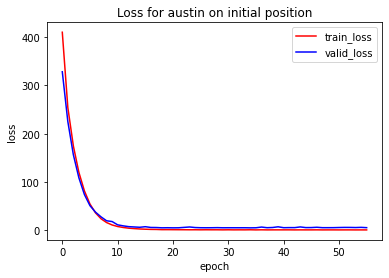

 20%|█▉        | 59/300 [08:42<35:34,  8.85s/it, loss=0.07664]

Stopped early at epoch 59 due to overfit


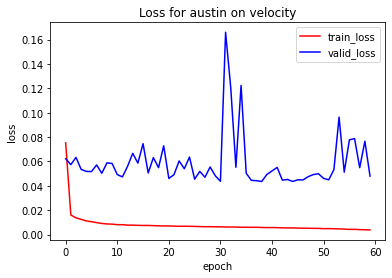

Total training time is: 9m 40s for austin
Training miami


 16%|█▋        | 33/200 [00:44<03:46,  1.36s/it, loss=7.08107] 

Stopped early at epoch 33 due to overfit


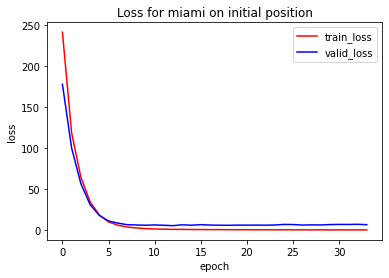

 10%|█         | 30/300 [05:40<51:03, 11.35s/it, loss=0.04216]

Stopped early at epoch 30 due to overfit


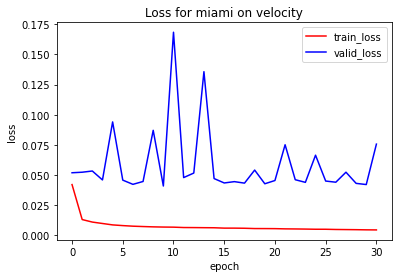

Total training time is: 6m 25s for miami
Training pittsburgh


 16%|█▋        | 33/200 [00:34<02:55,  1.05s/it, loss=4.39302] 


KeyboardInterrupt: 

In [57]:
%%time

# train one model for each city
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for city in cities:
    print('Training ' + str(city))
    train_dataset = ArgoverseDataset(city, 'train')
    val_dataset = ArgoverseDataset(city, 'val')

    X_train_nn_pos = train_dataset.nn_pos_inputs.to(device)
    y_train_nn_pos = train_dataset.nn_pos_outputs.to(device)
    X_train_nn_velo = train_dataset.nn_velo_inputs.to(device)
    y_train_nn_velo = train_dataset.nn_velo_outputs.to(device)
    X_train = train_dataset.input_positions.to(device)
    y_train = train_dataset.output_positions.to(device)

    X_val_nn_pos = val_dataset.nn_pos_inputs.to(device)
    y_val_nn_pos = val_dataset.nn_pos_outputs.to(device)
    X_val_nn_velo = val_dataset.nn_velo_inputs.to(device)
    y_val_nn_velo = val_dataset.nn_velo_outputs.to(device)
    X_val = val_dataset.input_positions.to(device)
    y_val = val_dataset.output_positions.to(device)

    start_time = time.time()
    nn_pos = lstm_encoder_decoder2.lstm_seq2seq(
        input_size=2,
        hidden_size=64,
        num_layers=2,
        dropout=0.3
    )

    nn_pos.to(device)

    train_losses_pos, valid_losses_pos = lstm_encoder_decoder2.train_model(
        nn_pos,
        city,
        X_train_nn_pos,
        y_train_nn_pos,
        X_val_nn_pos,
        y_val_nn_pos,
        n_epochs=200,
        target_len=1,
        batch_size=256,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.001,
        dynamic_tf=False,
        early_stop_criteria=20,
        device=device
    )

    plt.title("Loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_pos, color="red", label="train_loss")
    plt.plot(valid_losses_pos, color="blue", label="valid_loss")
    plt.legend()
    plt.show()


    nn_velo = lstm_encoder_decoder2.lstm_seq2seq(
        input_size=2,
        hidden_size=256,
        num_layers=3,
        dropout=0.3
    )

    nn_velo.to(device)

    train_losses_velo, valid_losses_velo = lstm_encoder_decoder2.train_model(
        nn_velo,
        city,
        X_train_nn_velo,
        y_train_nn_velo,
        X_val_nn_velo,
        y_val_nn_velo,
        n_epochs=300,
        target_len=59,
        batch_size=256,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.00005,
        dynamic_tf=False,
        early_stop_criteria=20,
        device=device
    )

    plt.title("Loss for " + city + " on velocity")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_velo, color="red", label="train_loss")
    plt.plot(valid_losses_velo, color="blue", label="valid_loss")
    plt.legend()
    plt.show()

    end_time = time.time()
    train_mins, train_secs = train_time(start_time, end_time)
    print(
        f'Total training time is: {train_mins}m {train_secs}s' + ' for ' + city)




### Check final validation loss (bad runtime now for sequential ingestion of data)

In [52]:
nn_pos.eval()
nn_velo.eval()

total_loss = 0
for n in range(val_dataset.__len__()):
    nn_pos_nth_input, nn_pos_nth_output, nn_velo_nth_input, nn_velo_nth_output, _, _, _, nth_output_centered = val_dataset.__getitem__(
        n)

    nn_pos_nth_input = nn_pos_nth_input.to(device)
    nn_pos_nth_output = nn_pos_nth_output.to(device)
    nn_velo_nth_input = nn_velo_nth_input.to(device)
    nn_velo_nth_output = nn_velo_nth_output.to(device)
    nth_output_centered = nth_output_centered.to(device)

    init_pos = lstm_encoder_decoder2.predict(nn_pos, nn_pos_nth_input, 1, device=device)
    deltas = lstm_encoder_decoder2.predict(nn_velo, nn_velo_nth_input, 59, device=device)
    total_loss += ((torch.cumsum(torch.cat((init_pos, deltas)),
                    dim=0) - nth_output_centered) ** 2).mean()

valid_loss = total_loss / val_dataset.__len__()

print("Final validation loss is: " + str(valid_loss) + " for " + city)


TypeError: can only concatenate str (not "Tensor") to str

### Generate CSV

In [ ]:
nn_pos.eval()
nn_velo.eval()
num_layers_pos = 2
num_layers_velo = 3

all_preds = []
for city in cities:
    test_dataset = ArgoverseDataset(city=city, split='test')
    rows = []
    model_pos = pickle.load(open('../models/seq2seq_lstm_' + str(num_layers_pos) + '_' + city, 'rb'))
    model_velo = pickle.load(open('../models/seq2seq_lstm_' + str(num_layers_velo) + '_' + city, 'rb'))
    for n in range(test_dataset.__len__()):
        if n % 1_000 == 0 and n > 0: 
            print(str(n) + ' predictions for ' + str(city) + ' completed.')
        nn_pos_nth_input, nn_velo_nth_input, center_input = test_dataset.__getitem__(n)
        nn_pos_nth_input = nn_pos_nth_input.to(device)
        nn_velo_nth_input = nn_velo_nth_input.to(device)
        center_input = center_input.to(device)
        init_pos = lstm_encoder_decoder2.predict(model_pos, nn_pos_nth_input, 1, device=device)
        deltas = lstm_encoder_decoder2.predict(model_velo, nn_velo_nth_input, 59, device=device)

        pred = (torch.cumsum(torch.cat((init_pos, deltas)), dim=0).flatten() + center_input).cpu().numpy()
        rows.append(pred)
    ids = np.array([str(i) + '_' + city for i in range(len(rows))])
    cols = np.array(['v' + str(i) for i in range(120)])
    predictions = pd.DataFrame(rows, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
all_predictions = pd.concat(all_preds, ignore_index=True)

1000 predictions for austin completed.
2000 predictions for austin completed.
3000 predictions for austin completed.
4000 predictions for austin completed.
5000 predictions for austin completed.
6000 predictions for austin completed.


AttributeError: Can't get attribute 'Seq2Seq' on <module '__main__'>

In [ ]:
all_predictions.to_csv('two_lstm_enc_dec_out.csv', index=False)